In [1]:
#Step 1 Data Preprocessing

C:\Users\USER\AppData\Local\Temp\ipykernel_1828\1772183391.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  links_df["tmdbId"].fillna(-1, inplace=True)


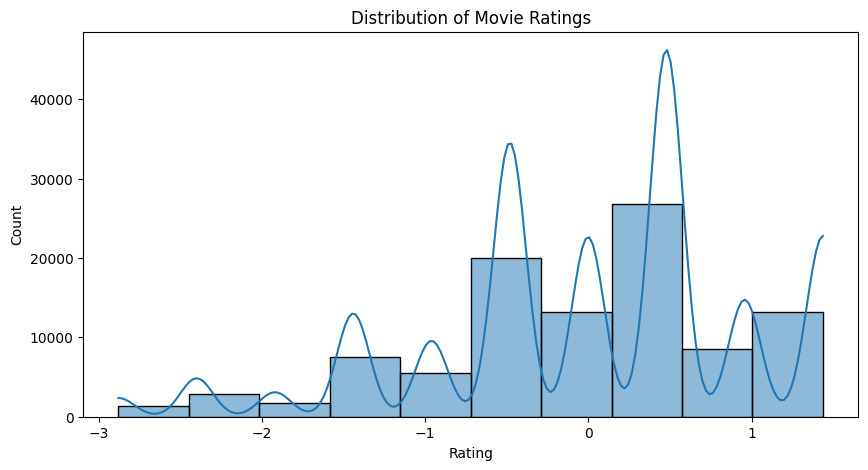

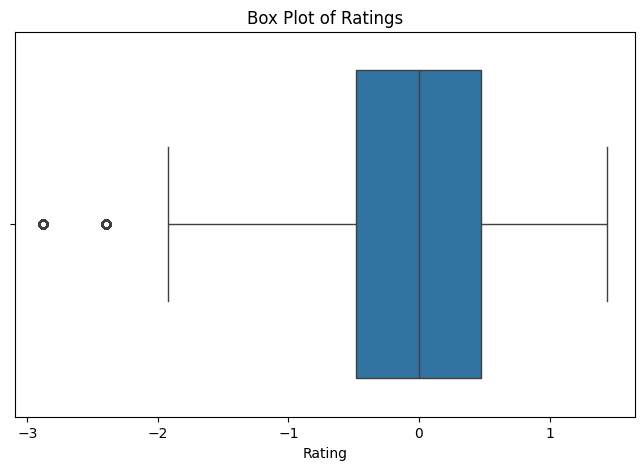

C:\Users\USER\AppData\Local\Temp\ipykernel_1828\1772183391.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")


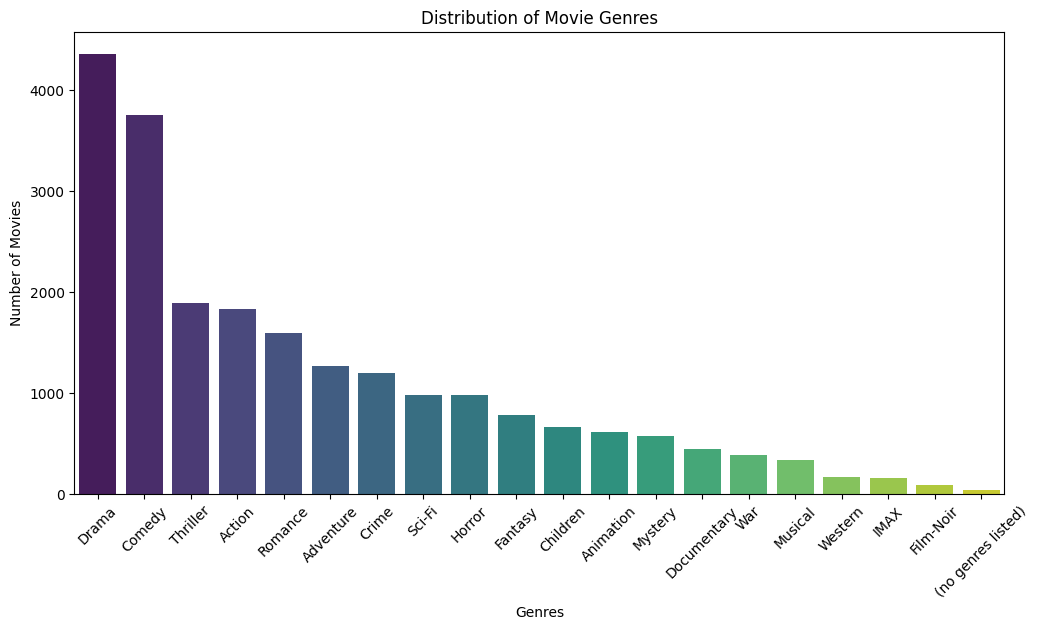

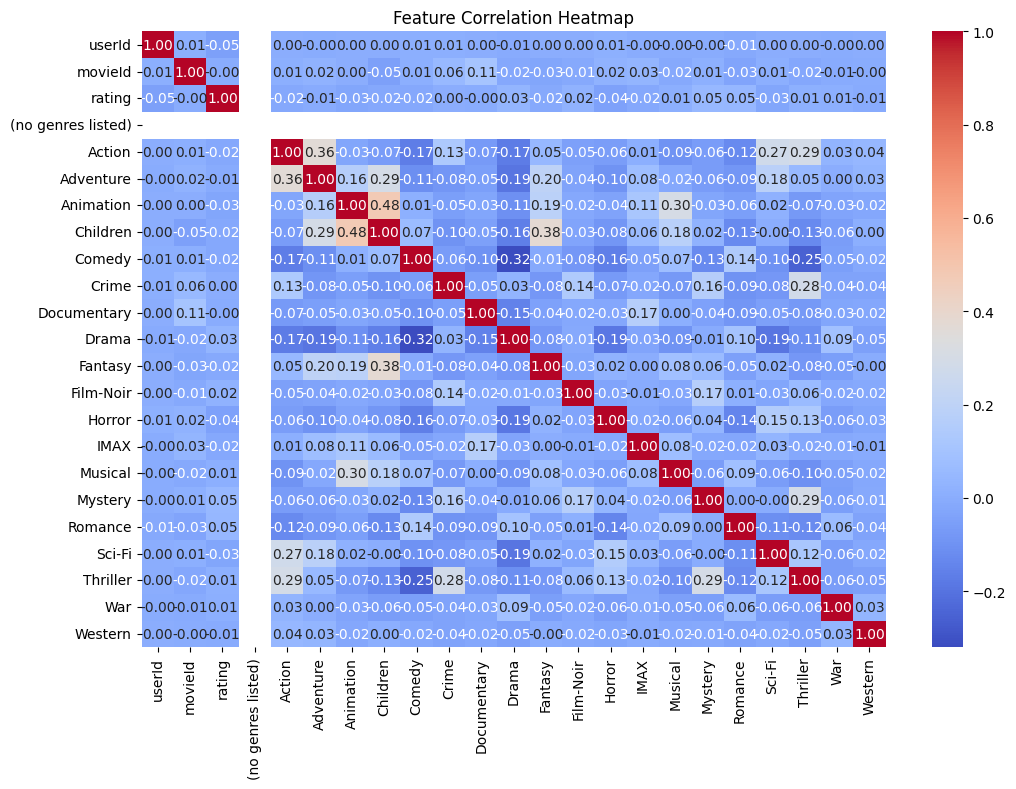

Processed Ratings Dataset:
   userId  movieId    rating
0       1        1  0.478112
1       1        3  0.478112
2       1        6  0.478112
3       1       47  1.437322
4       1       50  1.437322
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int32  
 1   movieId  100836 non-null  int32  
 2   rating   100836 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.2 MB
None
              userId        movieId        rating
count  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718  5.750268e-09
std       182.618491   35530.987199  1.000005e+00
min         1.000000       1.000000 -2.879125e+00
25%       177.000000    1199.000000 -4.810987e-01
50%       325.000000    2991.000000 -1.493475e-03
75%       477.000000    8122.000000  4.781117e-01
max       610.000000  193609.000000  1.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score


# Load MovieLens 100K dataset
ratings_path = 'ratings.csv'
movies_path = 'movies.csv'
tags_path = 'tags.csv'
links_path = 'links.csv'

# Load datasets
ratings_df = pd.read_csv(ratings_path)
movies_df = pd.read_csv(movies_path)
tags_df = pd.read_csv(tags_path)
links_df = pd.read_csv(links_path)

# remove duplicates
ratings_df.drop_duplicates(inplace=True)
movies_df.drop_duplicates(inplace=True)
tags_df.drop_duplicates(inplace=True)
links_df.drop_duplicates(inplace=True)


#Handle Missing Values by replacing  with -1
links_df["tmdbId"].fillna(-1, inplace=True)

#Remove Unnecessary Columns, timestamp isant useful for analysis and we also drop title which cant be use in analysis
ratings_df.drop(columns=["timestamp"], inplace=True)
tags_df.drop(columns=["timestamp"], inplace=True)
movies_df.drop(columns=["title"], inplace=True)

#Optimize Data Types for reducing  memory usage 
ratings_df = ratings_df.astype({"userId": "int32", "movieId": "int32", "rating": "float32"})
links_df = links_df.astype({"movieId": "int32", "imdbId": "int32", "tmdbId": "int32"})

#Process Genres (Sparse Encoding for Efficiency) (one hot encoding) ->
#we split the genres into lists, then each list on a different row and then we apply the one-hot encoding,
#by puting the value 1 in each genre the movie  belongs to and the others the value 0
movies_df["genres"] = movies_df["genres"].str.split("|")
genres_exploded = movies_df.explode("genres")
genres_one_hot = pd.get_dummies(genres_exploded["genres"], dtype=int)
movies_df_encoded = movies_df.drop(columns=["genres"]).join(
    genres_one_hot.groupby(genres_exploded["movieId"]).max()
)



#Normalize Rating Data (mean=0, std=1), for having a fair comparison between the ratings of the movies
scaler = StandardScaler()
ratings_df["rating"] = scaler.fit_transform(ratings_df[["rating"]])


#Merge Ratings with Movies for Further Analysis
ratings_with_genres = ratings_df.merge(movies_df_encoded, on="movieId", how="left")

# Exploratory Data Analysis (EDA)
# we see the frequency of different rating values after nomralization
plt.figure(figsize=(10, 5))
sns.histplot(ratings_df["rating"], bins=10, kde=True) # kde=true -> density estimate
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Movie Ratings")
plt.show()

# Box Plot of Ratings
# we see median, quartiles and outliers, the spread of rating gives insights into vraiance
# good for outlier handling
plt.figure(figsize=(8, 5))
sns.boxplot(x=ratings_df["rating"])
plt.xlabel("Rating")
plt.title("Box Plot of Ratings")
plt.show()

# Genre Distribution
# it shows the number of movies per genre
genre_counts = genres_exploded["genres"].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Genres")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movie Genres")
plt.show()

#corellation heatmap
#corellation coefficents between features, dark red= positive corellation, dark blue=negative corellation
plt.figure(figsize=(12, 8))
corr_matrix = ratings_with_genres.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()


# Display Processed Data
print("Processed Ratings Dataset:")
print(ratings_df.head())
print(ratings_df.info())
print(ratings_df.describe())

print("Processed Movies Dataset:")
print(movies_df_encoded.head())
print(movies_df_encoded.info())
print(movies_df_encoded.describe())

print("Ratings with  Movies Dataset:")
print(ratings_with_genres.head())
print(ratings_with_genres.info())
print(ratings_with_genres.describe())




In [3]:
#extra fixes

#parathroyntai NAN values, opote vazoyme thn timh 0 sth thesi toys
ratings_with_genres.fillna(0, inplace=True)
ratings_df.fillna(0, inplace=True)
movies_df_encoded.fillna(0, inplace=True)

#remove the no genres listed column
ratings_with_genres.drop(columns=["(no genres listed)"], inplace=True)

#ensure all data is numeric
print(ratings_with_genres.dtypes)
print(ratings_df.dtypes)
print(movies_df_encoded.dtypes)

userId           int32
movieId          int32
rating         float32
Action         float64
Adventure      float64
Animation      float64
Children       float64
Comedy         float64
Crime          float64
Documentary    float64
Drama          float64
Fantasy        float64
Film-Noir      float64
Horror         float64
IMAX           float64
Musical        float64
Mystery        float64
Romance        float64
Sci-Fi         float64
Thriller       float64
War            float64
Western        float64
dtype: object
userId       int32
movieId      int32
rating     float32
dtype: object
movieId                 int64
(no genres listed)    float64
Action                float64
Adventure             float64
Animation             float64
Children              float64
Comedy                float64
Crime                 float64
Documentary           float64
Drama                 float64
Fantasy               float64
Film-Noir             float64
Horror                float64
IMAX               

In [4]:
# Display Processed Data again, before moving to clustering
print("Processed Ratings Dataset:")
print(ratings_df.head())
print(ratings_df.info())
print(ratings_df.describe())

print("Processed Movies Dataset:")
print(movies_df_encoded.head())
print(movies_df_encoded.info())
print(movies_df_encoded.describe())

print("Ratings with  Movies Dataset:")
print(ratings_with_genres.head())
print(ratings_with_genres.info())
print(ratings_with_genres.describe())

Processed Ratings Dataset:
   userId  movieId    rating
0       1        1  0.478112
1       1        3  0.478112
2       1        6  0.478112
3       1       47  1.437322
4       1       50  1.437322
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int32  
 1   movieId  100836 non-null  int32  
 2   rating   100836 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.2 MB
None
              userId        movieId        rating
count  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718  5.750268e-09
std       182.618491   35530.987199  1.000005e+00
min         1.000000       1.000000 -2.879125e+00
25%       177.000000    1199.000000 -4.810987e-01
50%       325.000000    2991.000000 -1.493475e-03
75%       477.000000    8122.000000  4.781117e-01
max       610.000000  193609.000000  1.

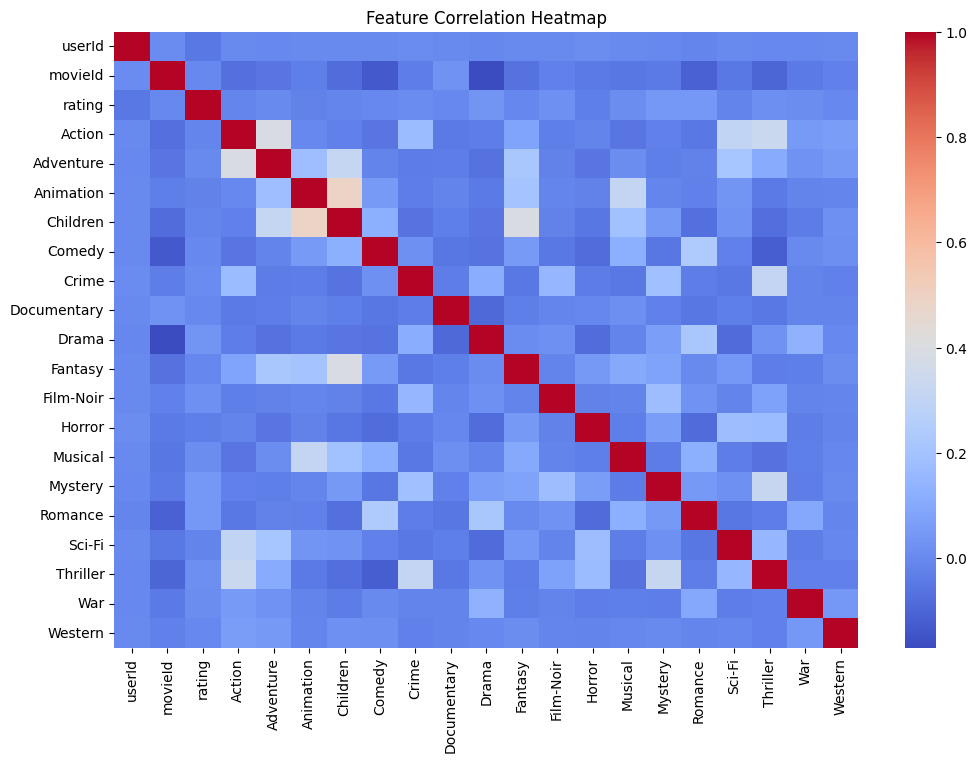

In [5]:
# final refinements

#handle spare genres, very reare genres <5% may distort clustering
genre_counts = ratings_with_genres.iloc[:, 3:].sum()  # Count genre presence
rare_genres = genre_counts[genre_counts < (0.05 * len(movies_df_encoded))].index  # Less than 5% presence
ratings_with_genres.drop(columns=rare_genres, inplace=True)

#check for highly correlated features, if 2 feautures are highly correlated , we might merge them
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(ratings_with_genres.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


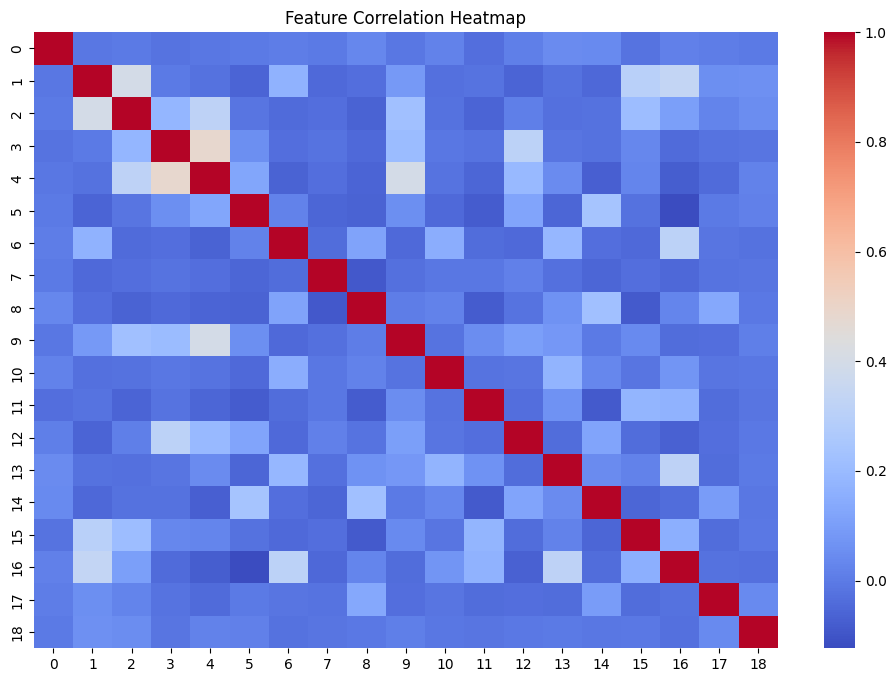


Results for K=3:
Silhouette Score: 0.29816035233894295
Davies-Bouldin Index: 1.5357875051210712
Calinski-Harabasz Index: 21105.537657423087


C:\Users\USER\AppData\Local\Temp\ipykernel_1828\2647526307.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


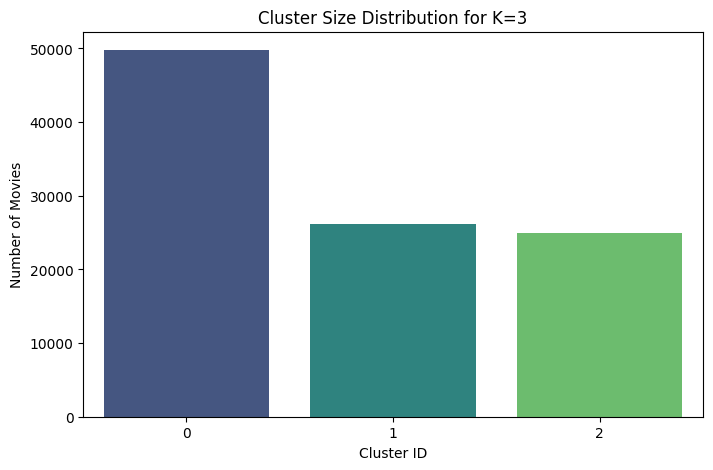


Results for K=4:
Silhouette Score: 0.3110106138964847
Davies-Bouldin Index: 1.5137929869841866
Calinski-Harabasz Index: 19447.776625297884


C:\Users\USER\AppData\Local\Temp\ipykernel_1828\2647526307.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


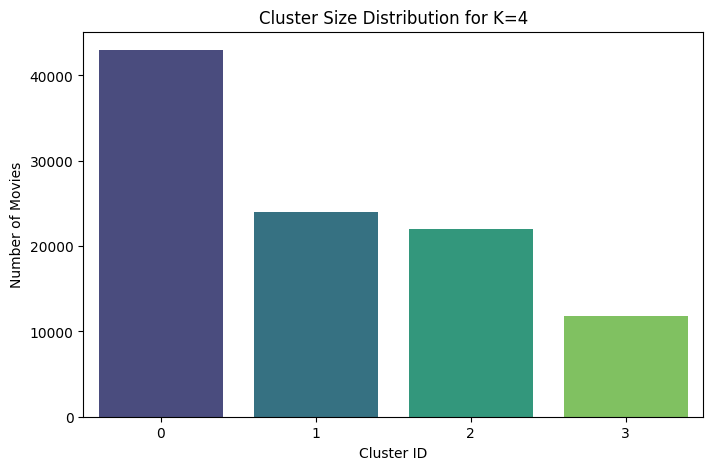


Results for K=5:
Silhouette Score: 0.33024993397546953
Davies-Bouldin Index: 1.5339011740330968
Calinski-Harabasz Index: 17720.09148268678


C:\Users\USER\AppData\Local\Temp\ipykernel_1828\2647526307.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


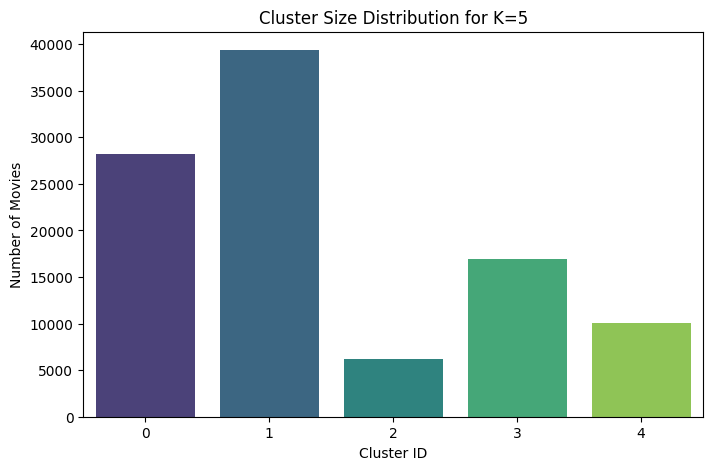


Results for K=6:
Silhouette Score: 0.3500703279122806
Davies-Bouldin Index: 1.646999784579777
Calinski-Harabasz Index: 16499.433858736727


C:\Users\USER\AppData\Local\Temp\ipykernel_1828\2647526307.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


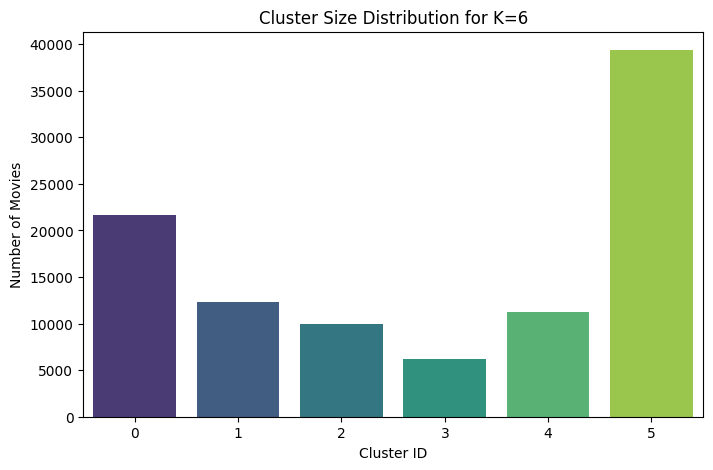


Results for K=7:
Silhouette Score: 0.3618466925428274
Davies-Bouldin Index: 1.5393124827798914
Calinski-Harabasz Index: 15878.00595724249


C:\Users\USER\AppData\Local\Temp\ipykernel_1828\2647526307.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


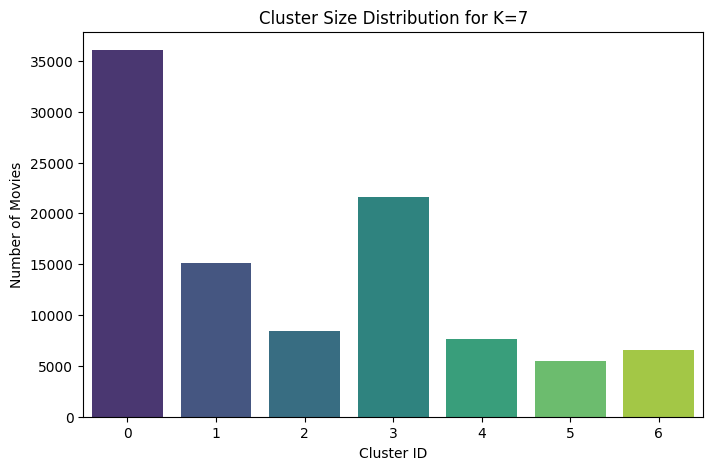


Results for K=8:
Silhouette Score: 0.3882461608824938
Davies-Bouldin Index: 1.414968140359518
Calinski-Harabasz Index: 15171.223435041338


C:\Users\USER\AppData\Local\Temp\ipykernel_1828\2647526307.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


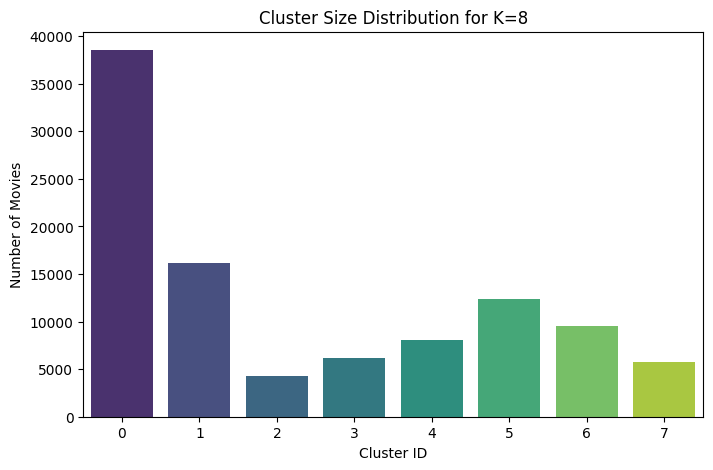


Results for K=9:
Silhouette Score: 0.38961732675830185
Davies-Bouldin Index: 1.4018514643463449
Calinski-Harabasz Index: 14996.31714195652


C:\Users\USER\AppData\Local\Temp\ipykernel_1828\2647526307.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


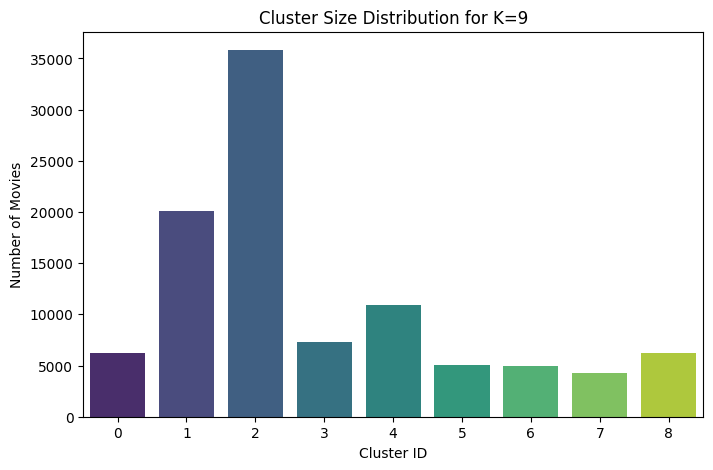


Results for K=10:
Silhouette Score: 0.412034447941302
Davies-Bouldin Index: 1.3784203824955685
Calinski-Harabasz Index: 14461.061064982123


C:\Users\USER\AppData\Local\Temp\ipykernel_1828\2647526307.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


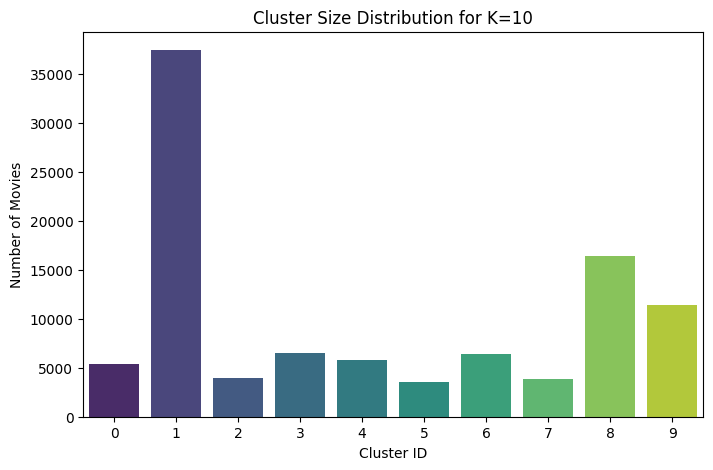

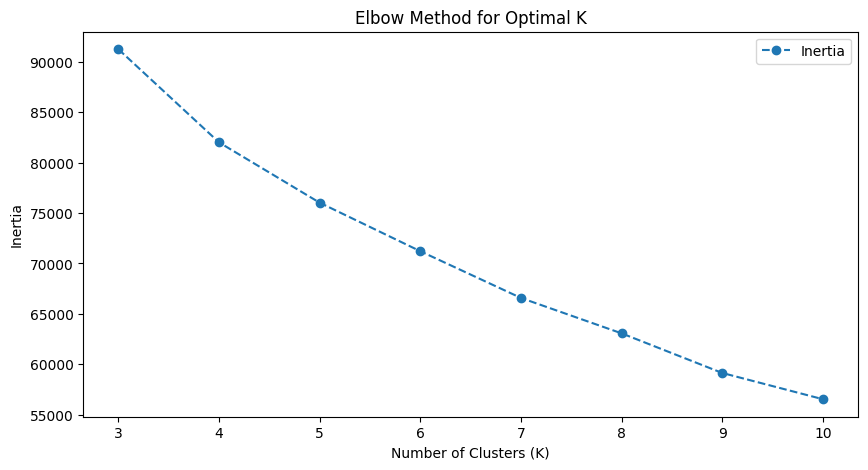

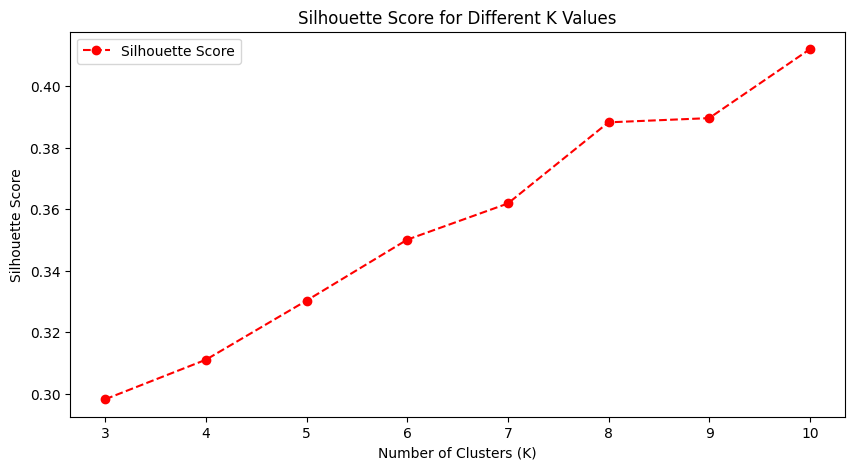

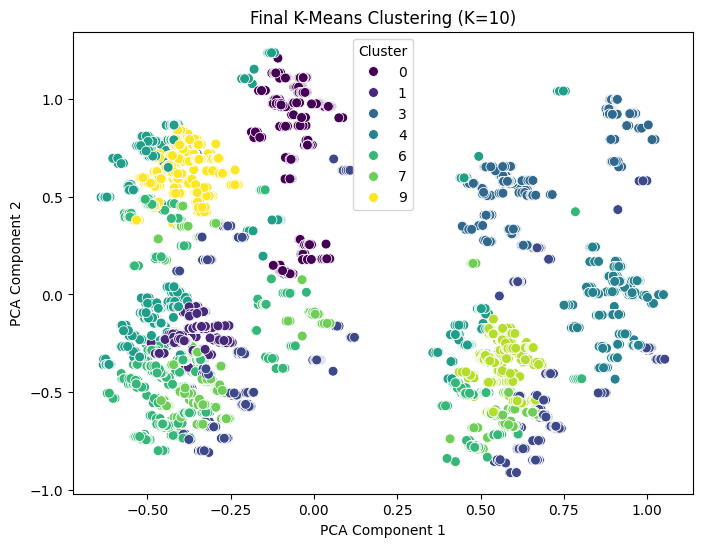


Best DBSCAN Parameters: eps=0.5, min_samples=3, Silhouette=0.7552159906548801


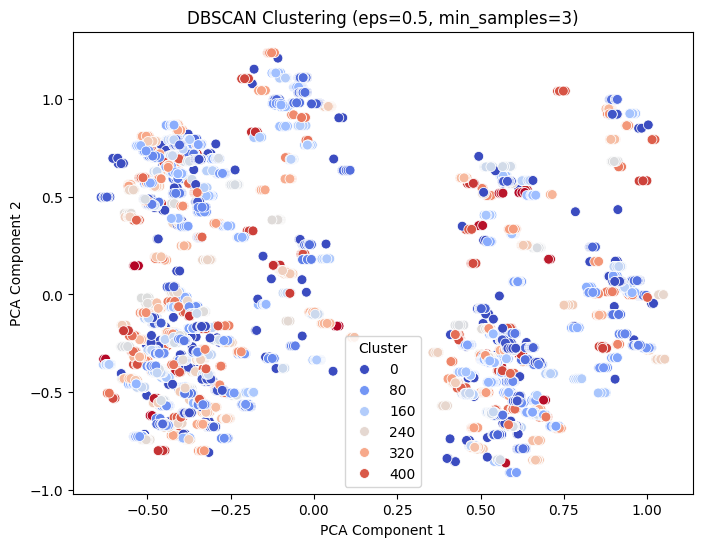

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Load and Preprocess Data
features = ratings_with_genres.drop(columns=['movieId', 'userId'], errors='ignore')

# Normalize Data using MinMaxScaler (Alternative to StandardScaler)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Check Feature Correlation
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(features_scaled).corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

# Finding the Best K for K-Means
K_range = range(3, 11)  # Avoid K=2
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
cluster_distributions = {}

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_scaled)
    
    inertia.append(kmeans.inertia_)
    sil_score = silhouette_score(features_scaled, labels)
    silhouette_scores.append(sil_score)
    davies_score = davies_bouldin_score(features_scaled, labels)
    davies_bouldin_scores.append(davies_score)
    ch_score = calinski_harabasz_score(features_scaled, labels)
    calinski_harabasz_scores.append(ch_score)
    
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    cluster_distributions[k] = cluster_counts
    
    print(f"\nResults for K={k}:")
    print(f"Silhouette Score: {sil_score}")
    print(f"Davies-Bouldin Index: {davies_score}")
    print(f"Calinski-Harabasz Index: {ch_score}")
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Movies")
    plt.title(f"Cluster Size Distribution for K={k}")
    plt.show()

# Plot Clustering Evaluation Metrics
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', label="Inertia")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='red', label="Silhouette Score")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K Values")
plt.legend()
plt.show()

# Optimal K Selection
best_k = max(K_range, key=lambda k: silhouette_score(features_scaled, KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(features_scaled)))
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_scaled)

# Visualizing Final K-Means Clusters using PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=kmeans_labels, palette="viridis", s=50)
plt.title(f"Final K-Means Clustering (K={best_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# DBSCAN Optimization
eps_values = [0.3, 0.32, 0.35, 0.38, 0.4, 0.5]
min_samples_values = [3, 4, 5, 6]
best_eps, best_min_samples, best_silhouette = None, None, -1
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(features_scaled)
        
        if len(set(labels)) > 1:
            sil_score = silhouette_score(features_scaled, labels)
            davies_score = davies_bouldin_score(features_scaled, labels)
            ch_score = calinski_harabasz_score(features_scaled, labels)
            outliers = np.sum(labels == -1)
            
            dbscan_results.append((eps, min_samples, sil_score, davies_score, ch_score, outliers))
            if sil_score > best_silhouette:
                best_silhouette = sil_score
                best_eps, best_min_samples = eps, min_samples

print(f"\nBest DBSCAN Parameters: eps={best_eps}, min_samples={best_min_samples}, Silhouette={best_silhouette}")

dbscan_opt = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels_opt = dbscan_opt.fit_predict(features_scaled)

# Visualizing DBSCAN Clusters using PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=dbscan_labels_opt, palette="coolwarm", s=50)
plt.title(f"DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()



In [ ]:
#fast dbscan

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.decomposition import PCA
# from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

# # Step 2: Clustering - Speeding Up DBSCAN

# # Reduce Feature Dimensionality with PCA for Faster DBSCAN
# pca = PCA(n_components=10)  # Reduce to 10 principal components
# features_reduced = pca.fit_transform(features_scaled)

# # Optimize DBSCAN with Reduced Feature Space
# eps_values = [0.45, 0.5, 0.55]  # Smaller range for efficiency
# min_samples_values = [3, 5]  # Reduce values to avoid excessive loops
# best_eps, best_min_samples, best_silhouette = None, None, -1
# dbscan_results = []

# for eps in eps_values:
#     for min_samples in min_samples_values:
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(features_reduced)  # Use PCA-reduced data

#         if len(set(labels)) > 1:
#             sil_score = silhouette_score(features_reduced, labels)
#             davies_score = davies_bouldin_score(features_reduced, labels)
#             ch_score = calinski_harabasz_score(features_reduced, labels)
#             outliers = np.sum(labels == -1)

#             dbscan_results.append((eps, min_samples, sil_score, davies_score, ch_score, outliers))
#             if sil_score > best_silhouette:
#                 best_silhouette = sil_score
#                 best_eps, best_min_samples = eps, min_samples

# print(f"\nBest DBSCAN Parameters: eps={best_eps}, min_samples={best_min_samples}, Silhouette={best_silhouette}")

# dbscan_opt = DBSCAN(eps=best_eps, min_samples=best_min_samples)
# dbscan_labels_opt = dbscan_opt.fit_predict(features_reduced)

# # Visualizing Optimized DBSCAN Clusters using PCA
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=features_reduced[:, 0], y=features_reduced[:, 1], hue=dbscan_labels_opt, palette="coolwarm", s=50)
# plt.title(f"Optimized DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})")
# plt.xlabel("PCA Component 1")
# plt.ylabel("PCA Component 2")
# plt.legend(title="Cluster")
# plt.show()


In [ ]:
#step2 and comparison

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.decomposition import PCA
# from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

# # Step 2: Clustering Comparison - K-Means vs. DBSCAN

# # Reduce Feature Dimensionality with PCA for Faster Clustering
# pca = PCA(n_components=10)
# features_reduced = pca.fit_transform(features_scaled)

# # Apply Optimized K-Means
# best_k = 5  # Assuming K=5 from previous analysis
# kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
# kmeans_labels = kmeans.fit_predict(features_reduced)

# # Apply Optimized DBSCAN
# best_eps = 0.5  # Use best DBSCAN parameters found earlier
# best_min_samples = 3
# dbscan_opt = DBSCAN(eps=best_eps, min_samples=best_min_samples)
# dbscan_labels_opt = dbscan_opt.fit_predict(features_reduced)

# # Compute Clustering Metrics
# silhouette_kmeans = silhouette_score(features_reduced, kmeans_labels)
# davies_bouldin_kmeans = davies_bouldin_score(features_reduced, kmeans_labels)
# ch_kmeans = calinski_harabasz_score(features_reduced, kmeans_labels)

# silhouette_dbscan = silhouette_score(features_reduced, dbscan_labels_opt) if len(set(dbscan_labels_opt)) > 1 else None
# davies_bouldin_dbscan = davies_bouldin_score(features_reduced, dbscan_labels_opt) if len(set(dbscan_labels_opt)) > 1 else None
# ch_dbscan = calinski_harabasz_score(features_reduced, dbscan_labels_opt) if len(set(dbscan_labels_opt)) > 1 else None

# # Print Clustering Comparison Results
# print("\nClustering Comparison:")
# print(f"K-Means (K={best_k}):")
# print(f"- Silhouette Score: {silhouette_kmeans:.4f}")
# print(f"- Davies-Bouldin Index: {davies_bouldin_kmeans:.4f}")
# print(f"- Calinski-Harabasz Index: {ch_kmeans:.4f}")

# print(f"\nDBSCAN (eps={best_eps}, min_samples={best_min_samples}):")
# print(f"- Silhouette Score: {silhouette_dbscan:.4f}")
# print(f"- Davies-Bouldin Index: {davies_bouldin_dbscan:.4f}")
# print(f"- Calinski-Harabasz Index: {ch_dbscan:.4f}")

# # Visualize Clusters with PCA
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # K-Means Visualization
# sns.scatterplot(x=features_reduced[:, 0], y=features_reduced[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[0], s=50)
# axes[0].set_title(f"K-Means Clustering (K={best_k})")
# axes[0].set_xlabel("PCA Component 1")
# axes[0].set_ylabel("PCA Component 2")
# axes[0].legend(title="Cluster")

# # DBSCAN Visualization
# sns.scatterplot(x=features_reduced[:, 0], y=features_reduced[:, 1], hue=dbscan_labels_opt, palette="coolwarm", ax=axes[1], s=50)
# axes[1].set_title(f"DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})")
# axes[1].set_xlabel("PCA Component 1")
# axes[1].set_ylabel("PCA Component 2")
# axes[1].legend(title="Cluster")

# plt.show()


In [11]:
kmeans_labels


array([1, 5, 9, ..., 1, 1, 1], dtype=int32)

In [8]:
dbscan_labels_opt

array([0, 1, 2, ..., 0, 0, 0])


Clustering Comparison:
K-Means (K=5):
- Silhouette Score: 0.3819
- Davies-Bouldin Index: 1.3549
- Calinski-Harabasz Index: 24412.1299

DBSCAN (eps=0.5, min_samples=3):
- Silhouette Score: 0.5902
- Davies-Bouldin Index: 1.1724
- Calinski-Harabasz Index: 4552.6653

K-Means Cluster Distribution:
3    39321
0    22926
4    21318
1    10428
2     6843
Name: count, dtype: int64

DBSCAN Cluster Distribution:
0      35046
3      12160
2       9053
4       4918
14      4007
       ...  
191        3
194        3
196        3
197        3
198        3
Name: count, Length: 201, dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_1828\2789577747.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kmeans_cluster_counts.index, y=kmeans_cluster_counts.values, ax=axes[0], palette="viridis")
C:\Users\USER\AppData\Local\Temp\ipykernel_1828\2789577747.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dbscan_cluster_counts.index, y=dbscan_cluster_counts.values, ax=axes[1], palette="coolwarm")


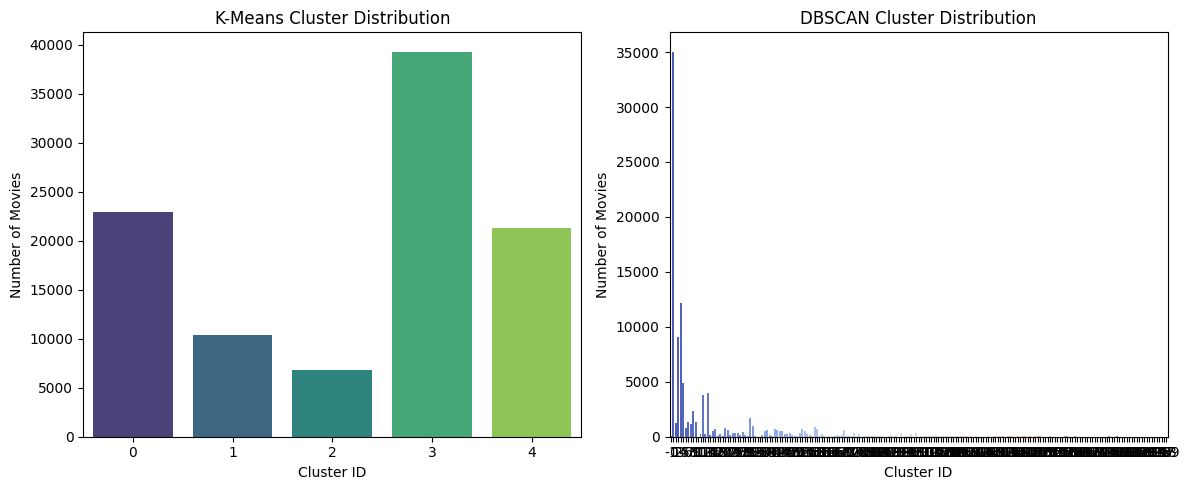

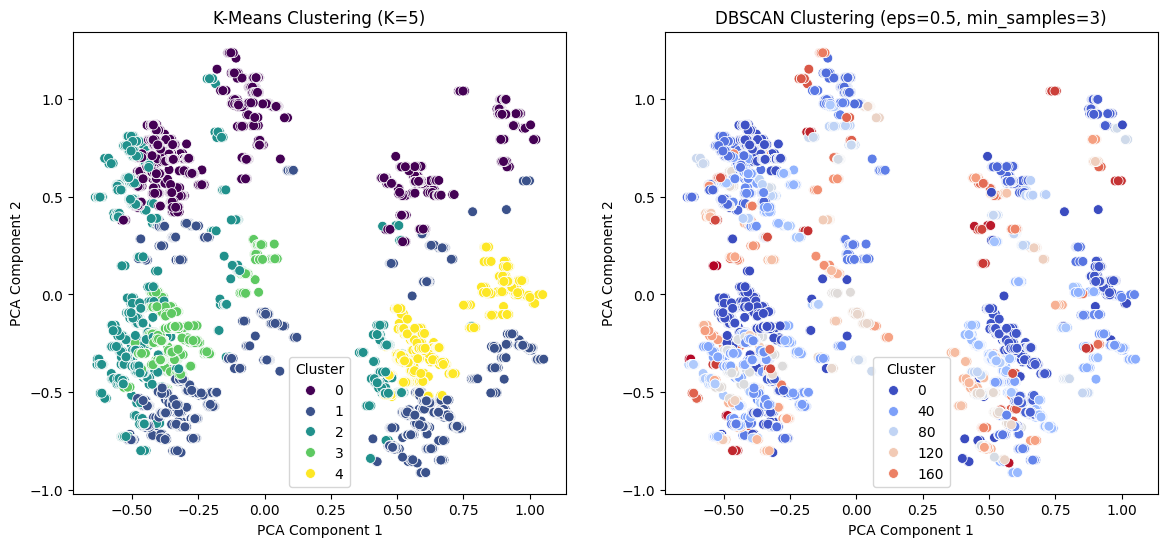

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score


# Step 2: Clustering Comparison - K-Means vs. DBSCAN

# Reduce Feature Dimensionality with PCA for Faster Clustering
pca = PCA(n_components=10)
features_reduced = pca.fit_transform(features_scaled)

# Apply Optimized K-Means
best_k = 5  # Assuming K=5 from previous analysis
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_reduced)

# Apply Optimized DBSCAN
best_eps = 0.5  # Use best DBSCAN parameters found earlier
best_min_samples = 3
dbscan_opt = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels_opt = dbscan_opt.fit_predict(features_reduced)


# Compute Clustering Metrics
silhouette_kmeans = silhouette_score(features_reduced, kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(features_reduced, kmeans_labels)
ch_kmeans = calinski_harabasz_score(features_reduced, kmeans_labels)

silhouette_dbscan = silhouette_score(features_reduced, dbscan_labels_opt) if len(set(dbscan_labels_opt)) > 1 else None
davies_bouldin_dbscan = davies_bouldin_score(features_reduced, dbscan_labels_opt) if len(set(dbscan_labels_opt)) > 1 else None
ch_dbscan = calinski_harabasz_score(features_reduced, dbscan_labels_opt) if len(set(dbscan_labels_opt)) > 1 else None

# Print Clustering Comparison Results
print("\nClustering Comparison:")
print(f"K-Means (K={best_k}):")
print(f"- Silhouette Score: {silhouette_kmeans:.4f}")
print(f"- Davies-Bouldin Index: {davies_bouldin_kmeans:.4f}")
print(f"- Calinski-Harabasz Index: {ch_kmeans:.4f}")

print(f"\nDBSCAN (eps={best_eps}, min_samples={best_min_samples}):")
print(f"- Silhouette Score: {silhouette_dbscan:.4f}")
print(f"- Davies-Bouldin Index: {davies_bouldin_dbscan:.4f}")
print(f"- Calinski-Harabasz Index: {ch_dbscan:.4f}")

# Detailed Cluster Label Analysis
print("\nK-Means Cluster Distribution:")
kmeans_cluster_counts = pd.Series(kmeans_labels).value_counts()
print(kmeans_cluster_counts)

print("\nDBSCAN Cluster Distribution:")
dbscan_cluster_counts = pd.Series(dbscan_labels_opt).value_counts()
print(dbscan_cluster_counts)

# Visualize Cluster Distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# K-Means Cluster Distribution
sns.barplot(x=kmeans_cluster_counts.index, y=kmeans_cluster_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("K-Means Cluster Distribution")
axes[0].set_xlabel("Cluster ID")
axes[0].set_ylabel("Number of Movies")

# DBSCAN Cluster Distribution
sns.barplot(x=dbscan_cluster_counts.index, y=dbscan_cluster_counts.values, ax=axes[1], palette="coolwarm")
axes[1].set_title("DBSCAN Cluster Distribution")
axes[1].set_xlabel("Cluster ID")
axes[1].set_ylabel("Number of Movies")

plt.tight_layout()
plt.show()

# Visualize Clusters with PCA
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# K-Means Visualization
sns.scatterplot(x=features_reduced[:, 0], y=features_reduced[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[0], s=50)
axes[0].set_title(f"K-Means Clustering (K={best_k})")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].legend(title="Cluster")

# DBSCAN Visualization
sns.scatterplot(x=features_reduced[:, 0], y=features_reduced[:, 1], hue=dbscan_labels_opt, palette="coolwarm", ax=axes[1], s=50)
axes[1].set_title(f"DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")
axes[1].legend(title="Cluster")

plt.show()



Model: Random Forest
Accuracy: 0.7742
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83      1360
         1.0       0.61      0.68      0.64       589

    accuracy                           0.77      1949
   macro avg       0.73      0.75      0.74      1949
weighted avg       0.78      0.77      0.78      1949



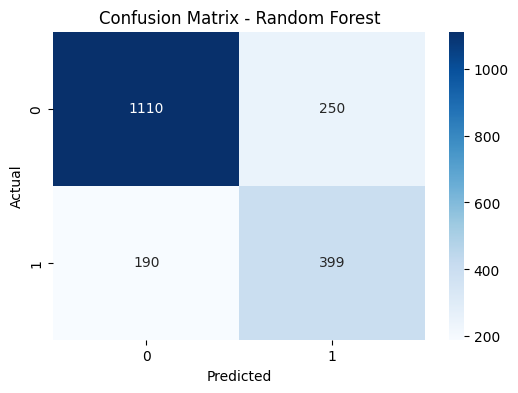

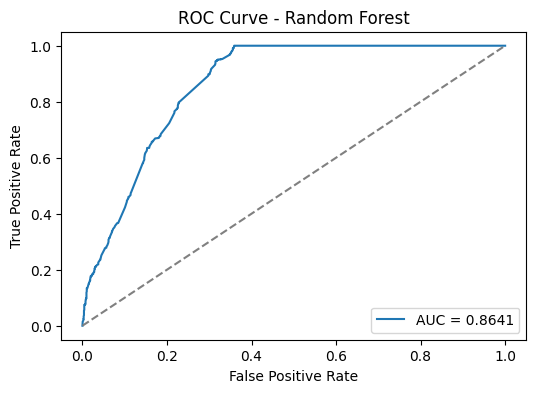

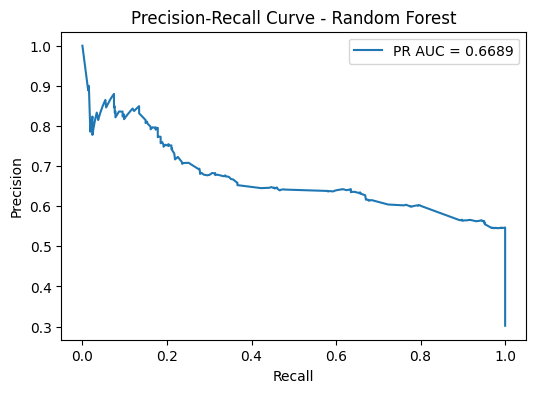


Model: SVM
Accuracy: 0.7809
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84      1360
         1.0       0.63      0.68      0.65       589

    accuracy                           0.78      1949
   macro avg       0.74      0.75      0.75      1949
weighted avg       0.79      0.78      0.78      1949



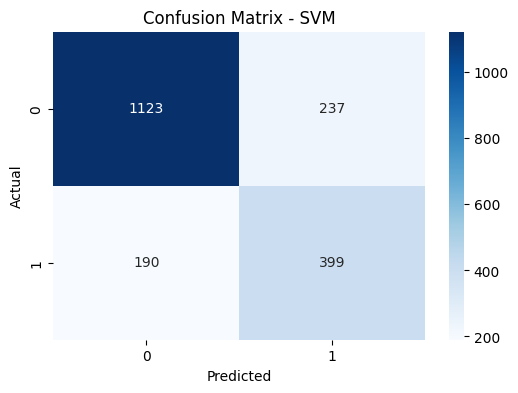

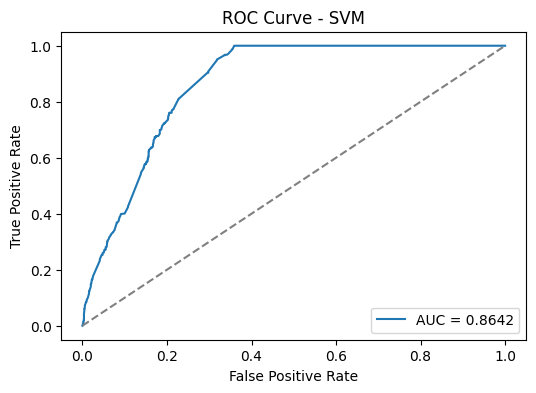

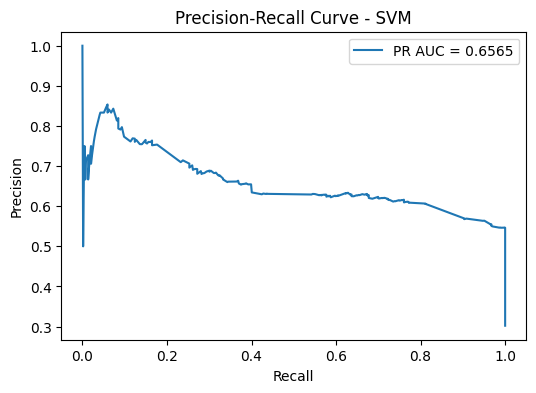


Model: Neural Network
Accuracy: 0.7768
              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83      1360
         1.0       0.61      0.74      0.67       589

    accuracy                           0.78      1949
   macro avg       0.74      0.77      0.75      1949
weighted avg       0.79      0.78      0.78      1949



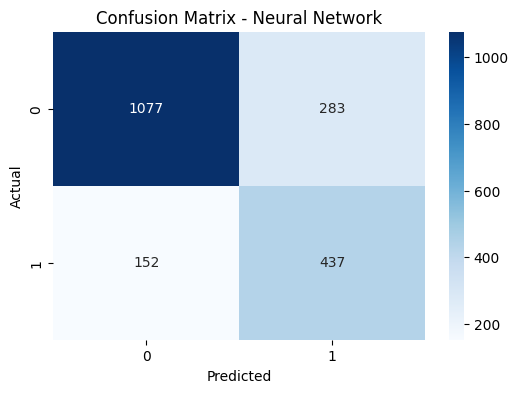

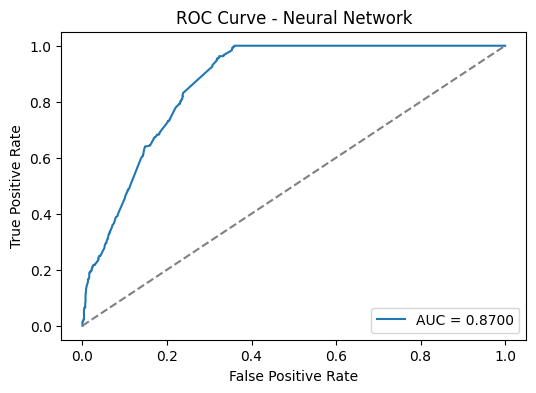

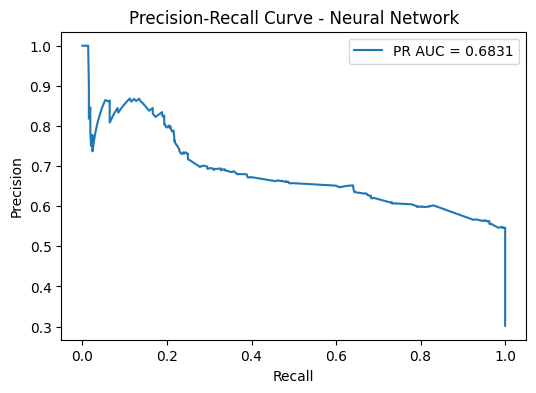

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Step 3: Classification - Predicting Movie Popularity

# Define 'is_popular' target variable (1 if above median number of ratings, 0 otherwise)
ratings_count = ratings_df.groupby('movieId')['rating'].count()
movies_df['is_popular'] = (ratings_count > ratings_count.median()).astype(int)

# Merge with movie features
movies_with_features = movies_df_encoded.merge(movies_df[['movieId', 'is_popular']], on='movieId', how='left')
movies_with_features.fillna(0, inplace=True)

# Prepare dataset for classification
X = movies_with_features.drop(columns=['movieId', 'is_popular'])  # Features
y = movies_with_features['is_popular']  # Target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train)
y_pred_rf = rf_clf.predict(X_test_scaled)

# Train a Support Vector Machine (SVM) Classifier
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_test_scaled)

# Train a Neural Network (MLP Classifier)
nn_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
nn_clf.fit(X_train_scaled, y_train)
y_pred_nn = nn_clf.predict(X_test_scaled)

# Evaluation Metrics
models = {'Random Forest': (rf_clf, y_pred_rf), 'SVM': (svm_clf, y_pred_svm), 'Neural Network': (nn_clf, y_pred_nn)}
for model_name, (model, y_pred) in models.items():
    print(f'\nModel: {model_name}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # ROC-AUC Curve
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f"PR AUC = {auc(recall, precision):.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.legend()
    plt.show()
